In [1]:
from unityagents import UnityEnvironment
import numpy as np
from dqn_agent import Agent
from collections import deque
import torch
import pickle
import matplotlib.pyplot as plt


# Load the environment
env = UnityEnvironment(file_name = "Banana/Banana.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Get handle to later interact with the environment
env_info = env.reset(train_mode=True)[brain_name]

# Get state and action information
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 13.46
Episode 200	Average Score: 13.25


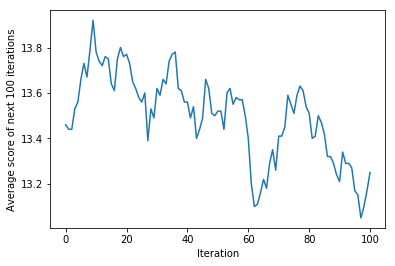

In [6]:
from dqn_agent import Agent
# Set this variable to True to train again. Caution: At the end of the training, the model.pt file will be replaced with the newly learned model
training = False

# Set the training parameters
max_t = 20000
max_episodes = 1000
eps_start=1.0
eps_end=0.01
eps_decay=0.995

num_layers = 1                         # number of hidden layers in the Q networks
num_units = 64                         # number of units in each hidden layer of the Q networks
for gamma in [0.99]:                   # iterate over a set of gamma values that need to be tried
    for tau in [1e-03]:                # iterate over a set of tau values that need to be tried
        
        averaged_score_history = []    # list containing scores from each episode
        
        if training:
            # Initialize the agent with the selected hyperparameters
            if num_layers > 1:    
                agent = Agent(state_size=state_size, action_size=action_size, seed=1, two_layers = True, fc1_units=num_units, fc2_units=num_units, gamma=gamma, tau=tau)
            else:
                agent = Agent(state_size=state_size, action_size=action_size, seed=1, two_layers = False, fc1_units=num_units, fc2_units=num_units, gamma=gamma, tau=tau)
        else:
            if num_layers > 1:    
                agent = Agent(state_size=state_size, action_size=action_size, seed=1, two_layers = True, fc1_units=num_units, fc2_units=num_units, gamma=gamma, tau=tau, model_file = 'model.pt')
            else:
                agent = Agent(state_size=state_size, action_size=action_size, seed=1, two_layers = False, fc1_units=num_units, fc2_units=num_units, gamma=gamma, tau=tau, model_file = 'model.pt')
            
        scores_window = deque(maxlen=100)  # last 100 scores
        eps = eps_start                    # initialize epsilon
        
        for i_episode in range(1, max_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]    
            state = env_info.vector_observations[0]
            done = False
            score = 0
            while not done:
                action =  np.int32(agent.act(state, eps))             # get action from the agent
                env_info = env.step(action)[brain_name]               # send the action to the environment
                next_state = env_info.vector_observations[0]          # get the next state
                reward = env_info.rewards[0]                          # get the reward
                done = env_info.local_done[0]                         # see if episode has finished
                if training:
                    agent.step(state, action, reward, next_state, done)   # put the memory in storage and possibly update Q networks
                state = next_state
                score += reward
                if done:
                    break 
            
            scores_window.append(score)
            
            if training:
                # update the epsilon used for the epsilon greedy policy
                eps = max(eps_end, eps_decay*eps)
            
            # If 100 or more episodes have passed, store the averaged score history
            if i_episode > 99:
                averaged_score_history.append(np.mean(scores_window))
            
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('')
            
            if (training and np.mean(scores_window)>=13.0): # Declare the system as solved if average has been > 13.0
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), 'model.pt')
                break
                
            if (not training and i_episode > 199): # End if the testing has gone for longer than 200 episodes
                break

plt.plot(averaged_score_history)
plt.xlabel('Iteration')
plt.ylabel('Average score of next 100 iterations')
plt.show()
